# Fraud Detection Using Random  Forest

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

###Dataset - https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

## Reading  data

In [2]:
#Reading the dataset
data = pd.read_csv(r"https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data")
data.shape 
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Cleaning Data

In [3]:
#cleaning data
if data.duplicated().sum() == 0:
    print('No, There aren\'t duplicate row|s in the dataset.')
else:
    print(f'Yes, There are {data.duplicated().sum()} duplicate row|s in the dataset.\n')
    data.drop_duplicates(inplace=True)
    print(data.shape) # (rows, columns)
    
if data.isnull().values.any():
    print('Unfortunately, there are missing values in the dataset.\n')
    print(data.isnull().sum()) # or print(data.isna().sum()) 
else:
    print('Fortunately, there aren\'t missing values in the dataset.')
    

No, There aren't duplicate row|s in the dataset.
Fortunately, there aren't missing values in the dataset.


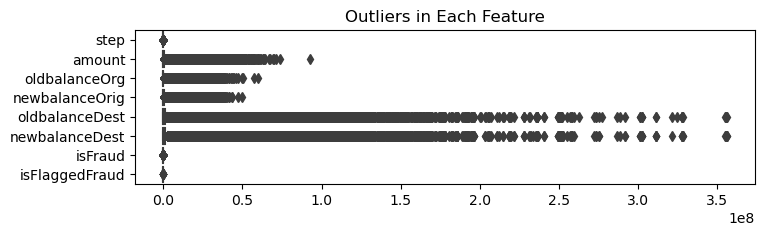

In [4]:
plt.figure(figsize=(8, 2))
sns.boxplot(data=data, orient='h')
plt.title('Outliers in Each Feature')
plt.show()

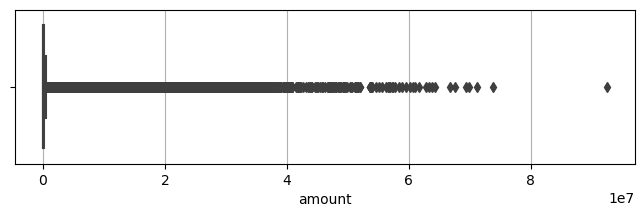

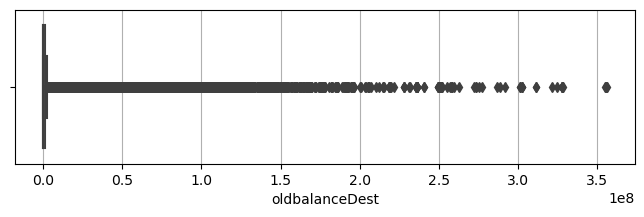

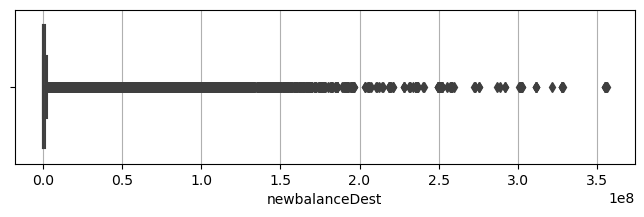

In [5]:
columns_to_plot = ['amount', 'oldbalanceDest', 'newbalanceDest']  
for column in columns_to_plot:
    if column in data.columns and data[column].dtype in ['int64', 'float64']:
        fig, axes = plt.subplots(1, figsize=(8, 2))
        sns.boxplot(x=data[column])
        plt.grid(axis='x')
        plt.show()
    else:
        print(f'Column {column} not found or not numerical.')

In [6]:
features = ['amount', 'oldbalanceDest', 'newbalanceDest']

for feature in features:
    lower_bound = data[feature].quantile(0.05)
    upper_bound = data[feature].quantile(0.95)
    outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
    data = data[~outliers]

print(data.shape)     

(5168039, 11)


## Analysis of the "type" feature

In [7]:
data['type'].unique()


array(['PAYMENT', 'DEBIT', 'CASH_OUT', 'TRANSFER', 'CASH_IN'],
      dtype=object)

In [8]:
data['type'].value_counts()

PAYMENT     1876452
CASH_OUT    1858616
CASH_IN     1181942
TRANSFER     228442
DEBIT         22587
Name: type, dtype: int64

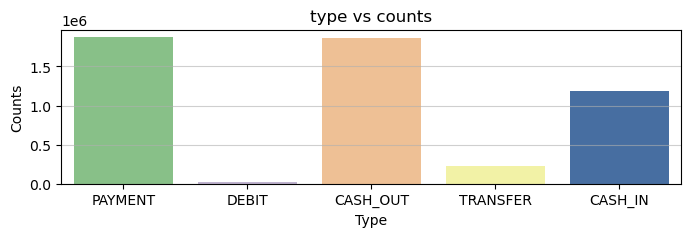

In [9]:
plt.figure(figsize=(8,2))
plt.title('type vs counts')
sns.countplot(data=data,x='type',palette='Accent')
plt.xlabel('Type')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [10]:
data['type'].replace({'CASH_OUT':0, 'PAYMENT':1, 'CASH_IN':2, 'TRANSFER':3, 'DEBIT':4}, inplace=True)


In [11]:
data['type'].value_counts()


1    1876452
0    1858616
2    1181942
3     228442
4      22587
Name: type, dtype: int64

In [12]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
4,1,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,1,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,1,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,1,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,1,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,4,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0
10,1,4,9644.94,C1900366749,4465.00,0.00,C997608398,10845.0,157982.12,0,0
11,1,1,3099.97,C249177573,20771.00,17671.03,M2096539129,0.0,0.00,0,0
12,1,1,2560.74,C1648232591,5070.00,2509.26,M972865270,0.0,0.00,0,0


## Analysis   of the "isFraud" feature

In [13]:
# check labels in "isFraud" feature
data.isFraud.unique()

array([0, 1], dtype=int64)

In [14]:
data['isFraud'].value_counts()

0    5163916
1       4123
Name: isFraud, dtype: int64

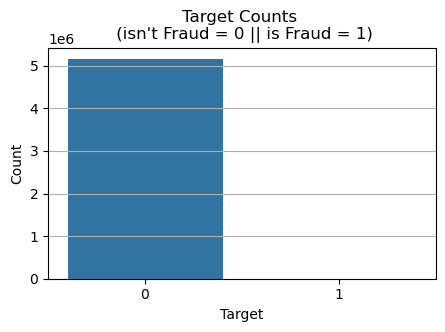

In [15]:
Target_counts = data['isFraud'].value_counts()

# Plot
plt.figure(figsize=(5, 3))
sns.barplot(x=Target_counts.index, y=Target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Counts \n (isn\'t Fraud = 0 || is Fraud = 1)')
plt.xticks()
plt.grid(axis='y')
plt.show()

In [16]:
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
data.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [17]:
data.shape

(5168039, 9)

## Corelation between features

In [18]:
# The correlation between features
data.corr()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.006730,-0.013481,-0.012156,-0.011885,-0.009932,-0.022277,0.023976,0.001632
type,0.006730,1.000000,0.019814,0.310743,0.324105,0.039126,-0.074857,0.018671,0.001408
amount,-0.013481,0.019814,1.000000,0.088077,0.098288,0.356692,0.427751,0.016436,0.001372
oldbalanceOrg,-0.012156,0.310743,0.088077,1.000000,0.999482,0.194578,0.109648,-0.006374,0.000980
newbalanceOrig,-0.011885,0.324105,0.098288,0.999482,1.000000,0.199321,0.109915,-0.008269,0.000963
oldbalanceDest,-0.009932,0.039126,0.356692,0.194578,0.199321,1.000000,0.965340,-0.009953,-0.000396
newbalanceDest,-0.022277,-0.074857,0.427751,0.109648,0.109915,0.965340,1.000000,-0.007713,-0.000424
isFraud,0.023976,0.018671,0.016436,-0.006374,-0.008269,-0.009953,-0.007713,1.000000,0.022016
isFlaggedFraud,0.001632,0.001408,0.001372,0.000980,0.000963,-0.000396,-0.000424,0.022016,1.000000


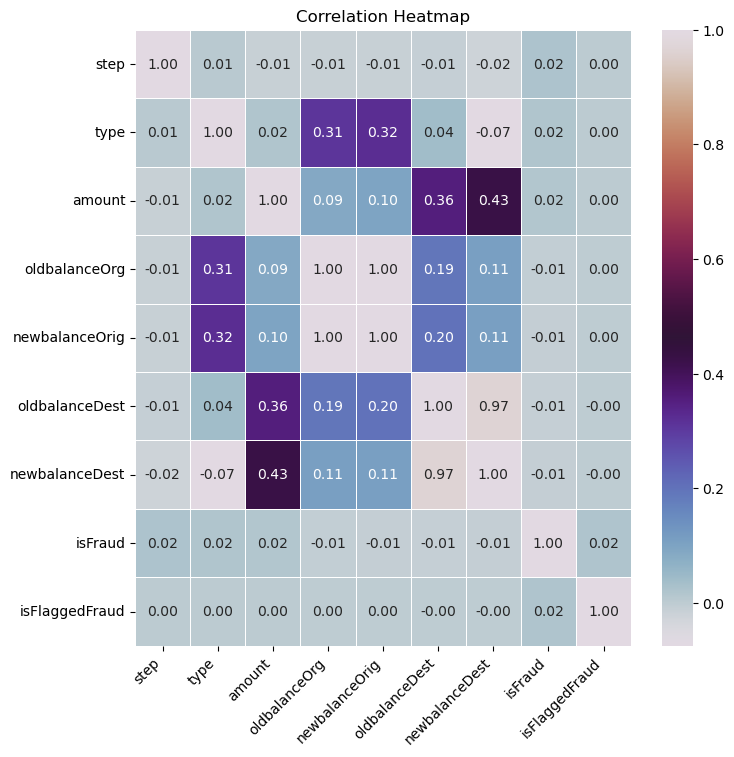

In [19]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, linewidths=0.7, fmt=".2f", cmap='twilight')
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()


In [20]:
#dropping the data on base of correlation
data.drop(['isFlaggedFraud'], axis=1, inplace=True)
data.drop(['step'], axis=1, inplace=True)

In [21]:
data.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [22]:
data.shape

(5168039, 7)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5168039 entries, 0 to 6362615
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int64(2)
memory usage: 315.4 MB


In [24]:
data.describe()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,5.168039e+06,5.168039e+06,5.168039e+06,5.168039e+06,5.168039e+06,5.168039e+06,5.168039e+06
mean,9.705828e-01,1.115780e+05,8.334547e+05,8.570534e+05,4.031965e+05,4.483916e+05,7.977881e-04
std,8.964483e-01,1.200733e+05,2.884098e+06,2.919460e+06,6.327152e+05,6.581748e+05,2.823388e-02
min,0.000000e+00,2.224100e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.389410e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,6.239752e+04,1.577700e+04,0.000000e+00,5.664439e+04,1.277501e+05,0.000000e+00
75%,2.000000e+00,1.805312e+05,1.099190e+05,1.592060e+05,5.618719e+05,6.516992e+05,0.000000e+00
max,4.000000e+00,5.186330e+05,4.368662e+07,4.367380e+07,4.777231e+06,2.914612e+06,1.000000e+00


## Training and Testing the Data

In [ ]:
# X Data
X = data.drop(['isFraud'], axis=1)
print('X shape is : ' , X.shape)
print()

# y Data
y = data['isFraud']
print('y shape is : ' , y.shape)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (3617627, 6)
X_test shape is  (1550412, 6)
y_train shape is  (3617627,)
y_test shape is  (1550412,)


In [27]:
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Train the Random Forest model
Model = RandomForestClassifier()
Model.fit(X_train_scaled, y_train)
y_pred_RF = Model.predict(X_test_scaled)

# Quick evaluation
Train_Accuracy = Model.score(X_train_scaled, y_train)
Test_Accuracy = Model.score(X_test_scaled, y_test)
print(f'Training accuracy: {Train_Accuracy*100:.2f} %')
print(f'Testing accuracy: {Test_Accuracy*100:.2f} %')

Training accuracy: 100.00 %
Testing accuracy: 99.97 %


In [39]:
predict = Model.predict(X_test)
accuracy = accuracy_score(y_test,predict)
print('actual     : ', y_test)
print('prediction : ' , predict)
print('accuracy   : ', accuracy)

actual     :  5017371    0
3894785    0
626795     0
4571370    0
5061809    0
          ..
1584099    0
2795280    0
6237170    1
3705162    0
2759735    0
Name: isFraud, Length: 1550412, dtype: int64
prediction :  [0 0 0 ... 0 0 0]
accuracy   :  0.9992440718983083


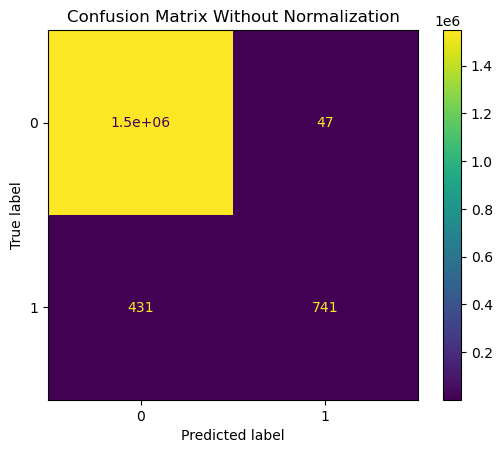

In [29]:

CM = confusion_matrix(y_true=y_test, y_pred=y_pred_RF)
ConfusionMatrixDisplay(CM, display_labels=data['isFraud'].unique()).plot()
plt.title('Confusion Matrix')
plt.show()

In [30]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1549240
           1       0.94      0.63      0.76      1172

    accuracy                           1.00   1550412
   macro avg       0.97      0.82      0.88   1550412
weighted avg       1.00      1.00      1.00   1550412



In [33]:
# Accuracy
Accuracy = accuracy_score(y_test, y_pred_RF)
print(f'Accuracy Score : {Accuracy * 100 :.2f} %\n')

# Precision
Precision = precision_score(y_test, y_pred_RF)
print(f'Precision Score : {Precision * 100 :.2f} %\n')

# Recall
Recall = recall_score(y_test, y_pred_RF)
print(f'Recall Score : {Recall * 100 :.2f} %\n')

# F1 Score
F1_Score = f1_score(y_test, y_pred_RF)
print(f'F1 Score : {F1_Score * 100 :.2f} %\n')

# ROC AUC
ROC_AUC = roc_auc_score(y_test, y_pred_RF)
print(f'ROC_AUC : {ROC_AUC * 100 :.2f} %\n')


Accuracy Score : 99.97 %

Precision Score : 94.04 %

Recall Score : 63.23 %

F1 Score : 75.61 %

ROC_AUC : 81.61 %



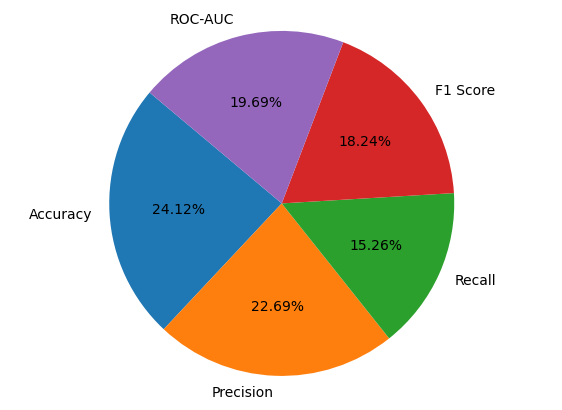

In [34]:
# Scores
Scores = [Accuracy, Precision, Recall, F1_Score, ROC_AUC]
Score_Names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

# Plot
plt.figure(figsize=(7, 5))
plt.pie(Scores, labels=Score_Names, autopct='%1.2f%%', startangle=140)
plt.axis('equal')
plt.show()